In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler,LabelEncoder
import seaborn as sns
import os
import warnings
from IPython.display import Image,HTML
from base64 import b64encode
def play(filename):
    html = ''
    video = open(filename,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=1000 controls autoplay loop><source src="%s" type="video/mp4"></video>' % src
    return HTML(html)

#prevent warning outputs
warnings.filterwarnings('ignore')

#Banner Image
Image("../input/databowl2021images/heat_banner2.png")

<a id='top'></a>
## Abstract

Machine Learning and other advanced statistical techniques helped to understand defensive performance and the factors that contribute to a successful pass play. We developed a Machine Learning model to predict coverages in real time. Football is a highly complex sport, with 22 players on the field who all contribute to the outcome of a specific play. Traditional box score statistics (such as pass completion rate) fail to capture the complexity of the game and do not accurately distribute the contribution of each individual player to the play outcome. We developed a number of objective metrics to measure defensive performance on pass plays and rank players.  We built models to extract the signal from the NGS data and assessed the models extensively using best practices. Our analysis and insights may be used on plays in real time and in review by NFL teams and the league office.

## Key Findings:
* The coverage schemes employed by the defense can be automatically detected by our machine learning model. This eliminates the need for manual labelling. Teams can also use this for film review and aggregating preformance data of their opponent.
*
* Our analysis quantifies that quarterbacks throw near the best defensive backs less often. One way we measure defensive player performance is based on where the quarterback chooses to throw the football (Defender Probability).  
* Using survival analysis we can clearly differentiate the performance of defensive backs. 
* We created two new metrics (CPAOE and 1stDAOE) that compare the performance of defensive backs. These metrics are effective in differentiating between the best and worst defensive backs. 
* Defensive pass interference can be accurately predicted using NGS data. Our analysis can be applied to predict the probability that each defensive back will commit defensive pass. And can ssist in quickly identifying worthy challanges.
* Using machine learning, we identified the best defensive backs against the pass. These players rankings are consistent with independent rankings such as ["All-Pro"](). **ADD LINK**



[Back To Top](#top) 
<a id='q1'></a>
# Analysis of Defense Coverage Schemes 

Identifying defensive coverage schemes used on play is a real challenge.  Attempts to do this manually by watching video are very time consuming and inefficient. On any given play, the defense can employ a wide variety of defensive coverage schemes, such as Man vs Zone, etc. We have developed a machine learning algorithm to automatically detect the schemes for every play. This technique could be used in real-time during the game and later in review for teams to identify which coverage schemes are used by opponents, and which schemes are most effective against the pass when evaluating their play designs. 

A stacked ensemble model was built to predict coverage schemes used by defensive teams and has an average weighted F1 score of 0.74 . We first needed to classify the defensive coverage schemes for each play. Coverage labels were provided by Telemetry Sports for the first week. We engineered over 70 features, such as average distance from line of scrimmage by position types. We first identified what coverage scheme the defense was using at the ball snap and throughout the play since defenses often disguise their coverages.  The model makes a prediction from the snap and for 20 frames of the play. We then aggregated the predictions for a select frame window to determine the predicted coverage scheme used. Because of the delay.

Using this method, we determined how often specific defensive coverage schemes were employed in the 2018 regular season and assessed which coverage schemes were better performing overall, and which schemes were most effective in specific play situations. The tradeoff between coverages is clearly visible in the interactive 3d plot below. We see a clear risk tradeoff between Cover 3 Zone and Cover 1 Man where Cover 3 Zone provides oportunity to intercept the ball for a turnover and Cover 1 Man offers lower completion percentage with about the same expected yardage results. Cover 3 trades off completions for potential interception/turnover opportunities which can turn the tide of a game vs a single 6yd completion they might have gotten anyways. Additionaly we see similar tradoff with Cover 4 Zone and Cover 2 Zone however not as many teams employ these coverages. Few defenses employ a Cover 0 Man and Cover 6 Zone as well.

There is a form of Cover 3 Zone that is "Pattern Matching" meaning they follow the routes of the receivers. If all run deep they keep cover 3 zone but if one cuts short they switch to cover 1 man. In general, it is possible to leverage the benifit of both Cover 3 Zone and Cover 1 Man. This is likey the reason all Defenses emply at least these two schemes and some only employ these two like Arizona.

In [ ]:
import plotly.express as px
plot_5d = pd.read_csv("../input/databowl2021images/5dplot.csv")

fig = px.scatter_3d(plot_5d, x='completion_prct', y='interception_prct', z='mean_offensePlayResult',
              color='coverage',symbol = 'defenseTeam', opacity=0.7)
fig.show()

In [ ]:
#Image("../input/databowl2021images/table_q2.png")

all_pred_df = pd.read_csv("../input/databowl2021images/all_defense_predictions.csv")
all_weeksfeatures = pd.read_csv("../input/databowl2021images/all_weeks_frame_features.csv")
all_weeksfeatures =all_weeksfeatures[all_weeksfeatures.ball_snap.fillna(False)]
games = pd.read_csv("../input/nfl-big-data-bowl-2021/games.csv")
plays = pd.read_csv("../input/nfl-big-data-bowl-2021/plays.csv")


In [ ]:
id_cols = ["gameId","playId"]
q2_df = pd.merge(all_pred_df[['gameId', 'playId', 'coverage']], plays[id_cols+['possessionTeam','passResult', 'offensePlayResult', 'playResult','epa', 'offenseFormation','isDefensivePI']], on=id_cols )
q2_df = pd.merge(q2_df, games[['gameId', 'homeTeamAbbr','visitorTeamAbbr']],on="gameId")
teams = dict(zip(q2_df.gameId,zip(q2_df.homeTeamAbbr, q2_df.visitorTeamAbbr)))
q2_df["defenseTeam"] = [teams[game][0] if teams[game][0]!= pos_team else teams[game][1] for game,pos_team in zip(q2_df.gameId, q2_df.possessionTeam)]

counts = q2_df[['defenseTeam',"coverage"]].groupby(['defenseTeam']).count().reset_index()

formation_c = q2_df.loc[q2_df.passResult == "C",["playId","coverage","offenseFormation"]].groupby(["offenseFormation","coverage"]).count().reset_index()
counts2 = q2_df[['playId', 'offenseFormation',"coverage"]].groupby(['offenseFormation',"coverage"]).count().reset_index()
formation_c = pd.merge(formation_c,counts2,on =['offenseFormation',"coverage"])
formation_c.columns = ["offenseFormation","coverage","count","total"]
formation_c["prct"] = formation_c["count"]/formation_c.total
formation_c[["coverage","offenseFormation","prct"]].pivot(index="coverage" , columns="offenseFormation" ,values="prct" ).reset_index().fillna(0)
print("Completion Percentages by Coverage and Offense Formation")

In [ ]:
formation_c[["coverage","offenseFormation","count"]].pivot(index="coverage" , columns="offenseFormation" ,values="count" ).reset_index().fillna(0)

In [ ]:
formation_c[["coverage","offenseFormation","total"]].pivot(index="coverage" , columns="offenseFormation" ,values="total" ).reset_index().fillna(0)

In [ ]:
# Set up 5d plot
formation_c = q2_df.loc[q2_df.passResult == "C",["playId","coverage","defenseTeam"]].groupby(["defenseTeam","coverage"]).count().reset_index()
formation_c = pd.merge(formation_c,counts,on =['defenseTeam'])
formation_c.columns = ["defenseTeam","coverage","count","total_play_count"]
formation_c["completion_prct"] = formation_c["count"]/formation_c.total_play_count

formation_in = q2_df.loc[q2_df.passResult == "IN",["playId","coverage","defenseTeam"]].groupby(["defenseTeam","coverage"]).count().reset_index()
formation_in = pd.merge(formation_in,counts,on =['defenseTeam'])
formation_in.columns = ["defenseTeam","coverage","count","total_play_count"]
formation_in["interception_prct"] = formation_in["count"]/formation_in.total_play_count

off_results = q2_df[["playId","coverage","defenseTeam","offensePlayResult"]].groupby(["defenseTeam","coverage"]).mean().reset_index()
counts2 = q2_df[['playId', 'defenseTeam',"coverage"]].groupby(['defenseTeam',"coverage"]).count().reset_index()
off_results = pd.merge(off_results[["defenseTeam","coverage","offensePlayResult"]],counts2,on =['defenseTeam',"coverage"])
off_results.columns = ["defenseTeam","coverage","mean_offensePlayResult","play_count"]

epa_results = q2_df[["playId","coverage","defenseTeam","epa"]].groupby(["defenseTeam","coverage"]).mean().reset_index()
counts2 = q2_df[['playId', 'defenseTeam',"coverage"]].groupby(['defenseTeam',"coverage"]).count().reset_index()
epa_results = pd.merge(epa_results[["defenseTeam","coverage","epa"]],counts2,on =['defenseTeam',"coverage"])
epa_results.columns = ["defenseTeam","coverage","mean_epa","play_count"]

plot_5d = pd.merge(formation_c[["defenseTeam","coverage","completion_prct"]],formation_in[["defenseTeam","coverage","interception_prct"]],on=["defenseTeam","coverage"])
plot_5d = pd.merge(plot_5d,off_results,on=["defenseTeam","coverage"])
plot_5d = pd.merge(plot_5d,epa_results[["defenseTeam","coverage","mean_epa"]],on=["defenseTeam","coverage"])
plot_5d = pd.merge(plot_5d,counts,on=["defenseTeam"])
plot_5d.columns = ["defenseTeam","coverage","completion_prct","interception_prct","mean_offensePlayResult", "play_count","mean_epa", "total_play_count"]
scaler = StandardScaler()
plot_5d.iloc[:,2:-2] = scaler.fit_transform(plot_5d.iloc[:,2:-2])

In [ ]:
Image("/kaggle/input/bdb2021/Figure1.png")

The animated heatplots show the layered plays of the defensive coverages for the 2018 season as they play out by frame. The X axis is zero at the line of scrimmage (LOS) and the center of field is divded at 0 on the Y axis. This illustrates the clear distinct patterns of each coverage scheme.

In [ ]:
Image("../input/databowl2021images/heat_banner.png")

In [ ]:
play('/kaggle/input/databowl2021images/coverage_heat_anim2.mp4')

In [ ]:
Image("/kaggle/input/figure/Figure2.png")

[Back To Top](#top) 
# Measuring Pass Defense By Player Performance

One way we measure defensive player performance is based on where the quarterback chooses to throw the football. When the quarterback drops back to make a pass, he has many options where he can throw the ball. The quarterback tries to throw the football to the location on the field that maximizes the chance of a successful play. We expect that the quarterback will tend to avoid throwing near those defensive backs who are doing a good job of covering offensive players. 

A supervised learning classification model was trained on some plays to predict the best location for the quarterback to throw the ball. The model was then evaluated on plays withheld during training. It accounts for many factors, such as how open the receiver is (distance from receiver and defender, the distance between the quarterback and receiver, and the respective accelerations of receiver and defensive back. Each defender is assigned a probability that the quarterback will throw to the receiver they are covering (Defender Probability). 

The model makes a prediction at every frame from snap to pass arrival.  The animation in Figure XX shows a pass play in the 2018 season, a link to the video is [HERE](https://www.youtube.com/watch?v=blKEUlq6yj8).   The Defender Probability is shown underneath each defensive back.  


In [ ]:
play('/kaggle/input/defenderprob/defenderprob_example.mp4')

In [ ]:
Image("/kaggle/input/bdb2021/Figure3.png")

# NFL’s best players against the pass

We examined the difficulty of a pass and compared this to the performance of a defnsive player to build objective performance metrics for each defensive players. We estimated the expected completion percentage of every passing play using the player tracking data. Passing plays have different probabilities of completion. For example, a short two pass to a wide-open running back has a very different probability than a 30-yard pass where there is little separation between the intended receiver and defender.  Using supervised learning techniques, we quantified the difficulty of a pass by accounting for many factors such as the distance traveled of the football, the separation between the intended receiver and defender, the proximity of the other defensive players, and the acceleration of the players.  These metrics can be used by teams to evaluate the performance of defensive back, and we have used these metrics to rank the best players.

We compared the completion percentage allowed relative to what would be expected and created a new metric called completion percentage allowed over expected (CPAOE).  A negative CPAOE indicates that the defensive back allowed less completions than expected and a positive CPAOE indicates that the defensive back allowed more completions than expected on average.  Eddie Jackson has a CPAOE of -.11 meaning that, on average, his completion percentage allowed in 2018 was 11 percent less than what was expected on those plays. This metric is similar to the NGS statistic “Completion percentage above expectation” (https://www.nfl.com/news/next-gen-stats-intro-to-completion-probability-part-ii-0ap3000000967238) 


We extended this analysis to consider that completed passes have different impacts on the outcome of a game. For example, a short 2-yard completion on third and ten has less impact compared to a 10-yard pass completion resulting in a first down. A defensive back may purposely allow a short completion in certain situations (like third down) where there are many yards needed to get a first down. Using the approach described above for CPAOE, we compared the expected first down rate allowed with the actual first downs allowed (1stDAOE). For example, Desmond King was the best defensive back in 2018 (among those who played at least 250 snaps) according to this metric. Desmond had a 1stDAOE of -.19 meaning, on average, his first down rate allowed was 19 percent less than what was expected. 

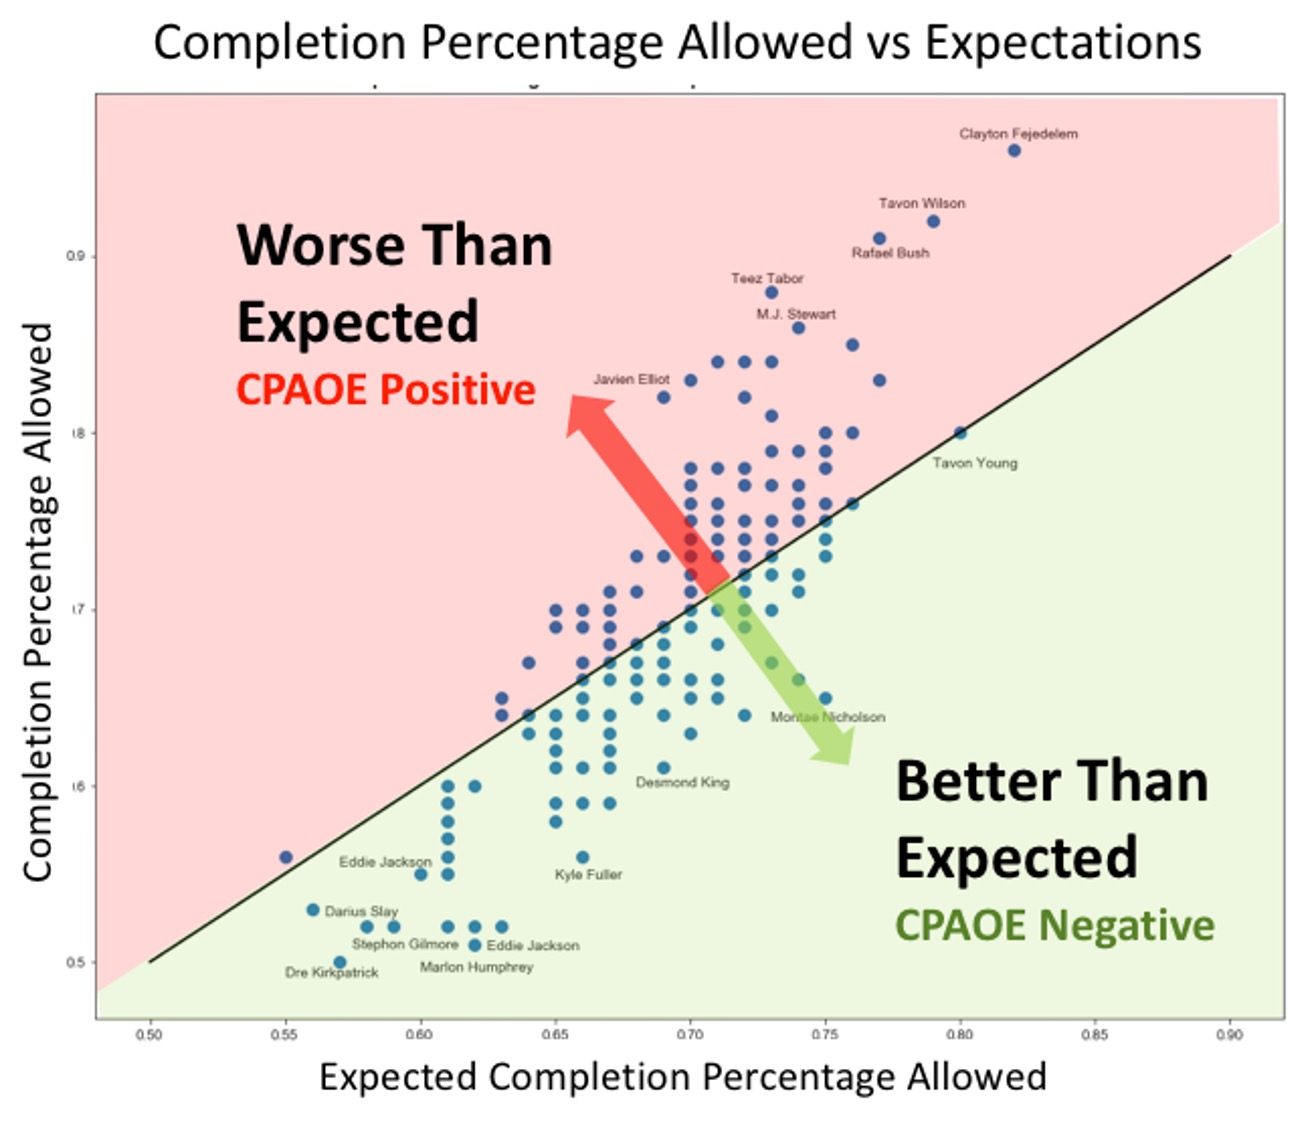

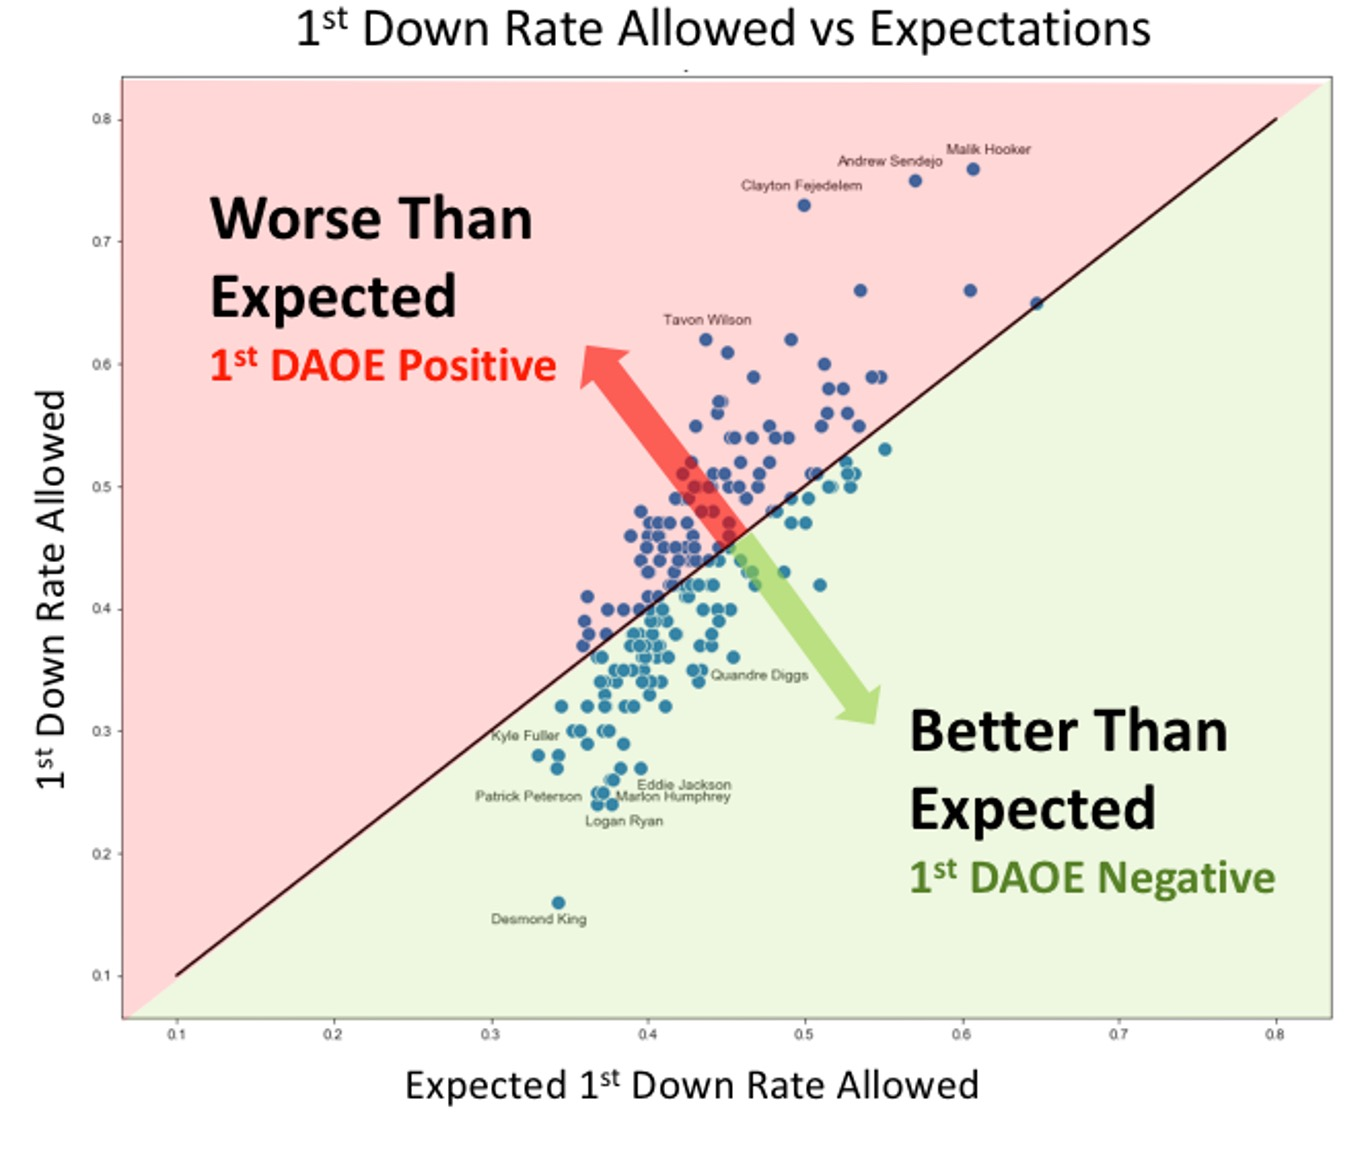

In [ ]:
Image("/kaggle/input/bdb2021/Figure4.jpg")

Survival analysis is a useful way to compare the performance of defensive backs on pass plays. Survival analysis was originally developed in the field of medicine to analyze the lifespan of individuals. It is a set of statistical approaches to analyze the expected time it will take for an event to occur. For pass analysis, time is the number of snaps for each defensive back and the event of interest is whether the defensive back covered the intended receiver. Our hypothesis is that best defensive players effectively neutralize the part of the field they are covering against the pass, and therefore the quarterback will on average throw near the best defenders less often. On a survival curve for the pass it will take more snaps for the best defensive players to be targeted in coverage. Survival curves were created for each defensive back in the 2018 regular season. For example, Figure xx below shows the survival curves for Stephon Gilmore and Kyle Fuller (two of the best defensive backs based on our analysis and widely considered the best), Ken Crawley, and Jamar Taylor. The shaded area on each curve indicates the confidence interval. The flatter curves and curves towards the upper right indicate that it more snaps until that defensive back was covering the intended receiver.  

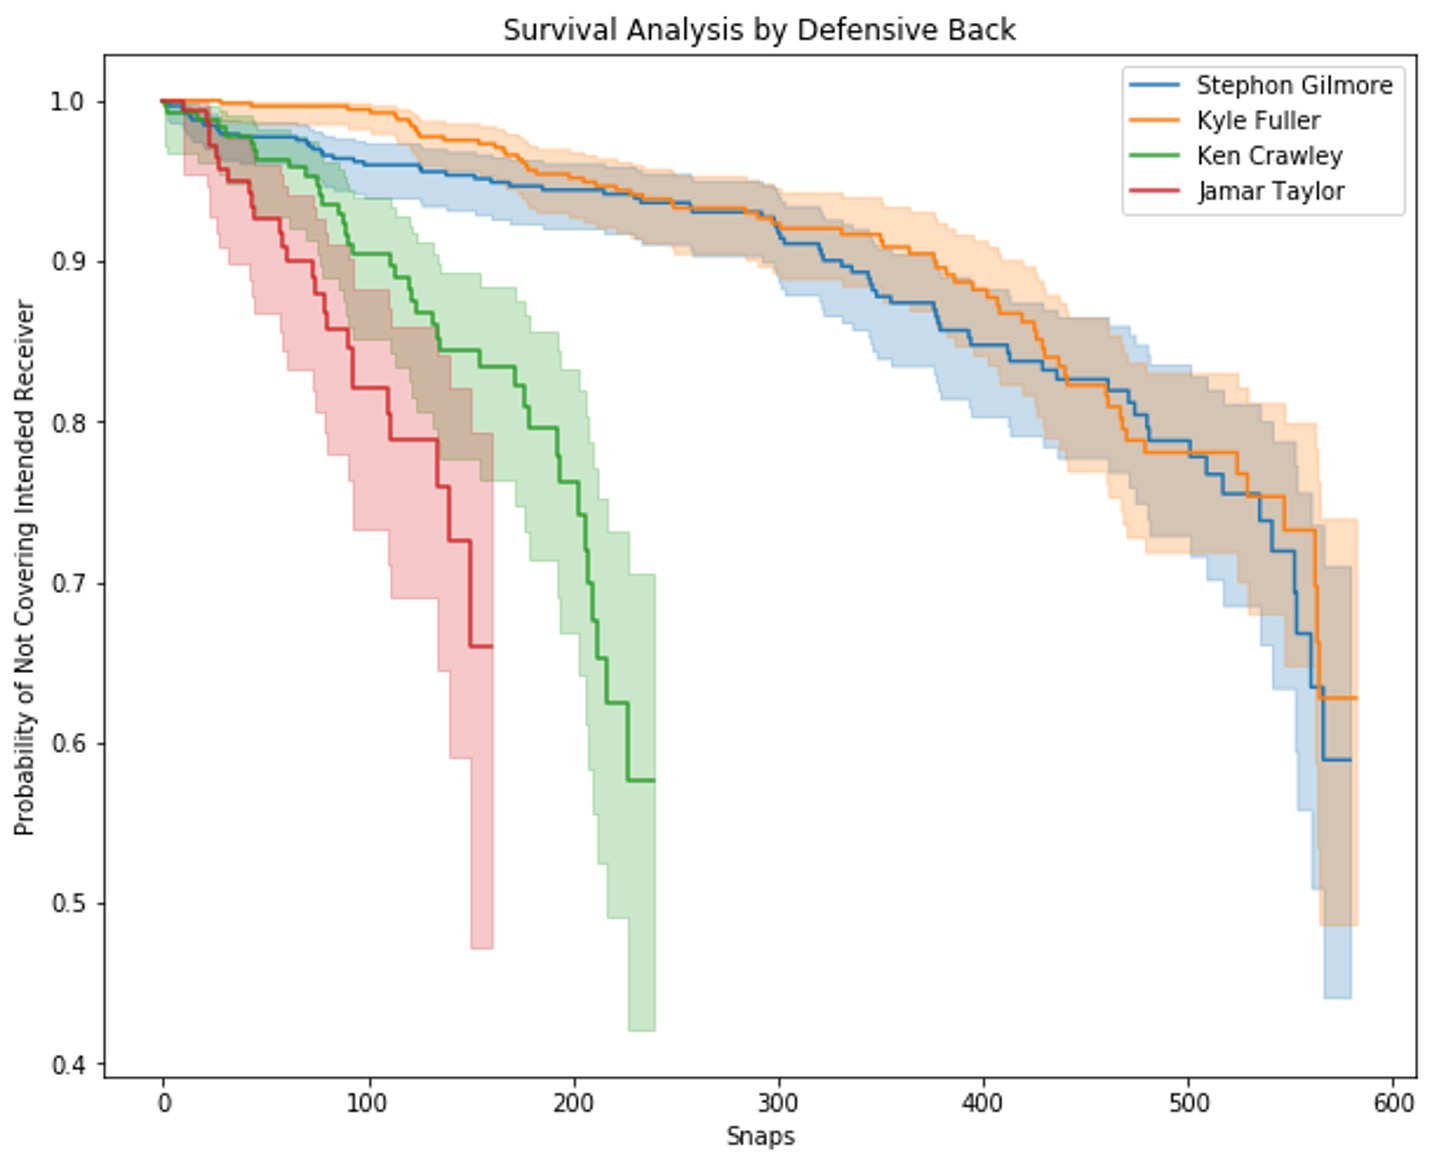

In [ ]:
Image("/kaggle/input/bdb2021/Figure5.jpg")

# Defensive Pass Interference

Defensive pass interference occurs when a defensive player significantly impacts a receiver’s ability to catch the ball. Defensive pass interference has a big impact in the outcome of the game since it results in automatic first down at the spot that the foul occurred. We trained a supervised machine learning model to learn the specific factors that were associated with a higher probability of defensive pass interference and then have it generalize to unseen plays. The model has good predictability using standard evaluation measures (AUC of .90 from 10-fold cross validation). 

The distance between the intended receiver and defender is the most important factor in the model’s prediction of pass interference.  The proximity of the football to the defender is important because pass interference is more likely to be called if the pass is catchable.  The angular difference of the defender is significant because a lower angle difference may indicate the defensive back is not making a play on the ball but is attempting to tackle the receiver in an attempt to break up the pass.  

The model predicts the probability of committing pass interference for every back on the field for every 0.1 second during the play, while the ball is in the air. This probability changes over time based on the player tracking data. Figure xx below shows an animation of a specific play in the 2018 regular season game of the Denver Broncos vs San Diego Chargers where Bradley Roby committed defensive pass interference on Keenan Allen. Here the model correctly predicts that Bradley Roby has committed defensive pass interference.

In [ ]:
from IPython.display import HTML
from base64 import b64encode

def play(filename):
    html = ''
    video = open(filename,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=1000 controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
    return HTML(html)

play('/kaggle/input/dpiexample/dpiplayexample.mp4')

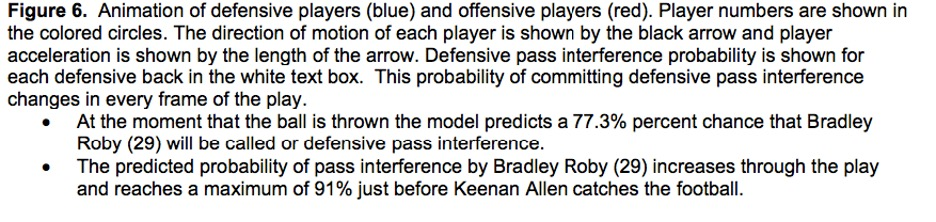

# Attributes of Defensive Backs

We found interesting differences in the distribution of age, height, weight and maximum deceleration over a play for each of the quartiles of performance. The best defensive backs tend to be in their prime (centered around median age of 27.1) at their physical peak and multiple seasons of NFL experience. (Figure YY).  The bottom quartile performers tend to be young (median age of 25.7) as it takes several years to adapt to NFL game standards.  The age distribution of average players is bi-modal cluster with some older (29 years) and very young players (24 years). 

Interestingly, the best defensive backs tend to have a higher maximum deceleration on plays. This may indicate greater athletic ability and ability to cover the receiver in space. Further analysis is needed on this attribute, but if deceleration is confirmed to correlate with better performance it may be helpful for teams to measure this during scouting and player evaluation. The best defensive backs tend to have shorter height (centered at 71 inches) and tend to be slightly heavier compared to the poorer quartiles of performance. 
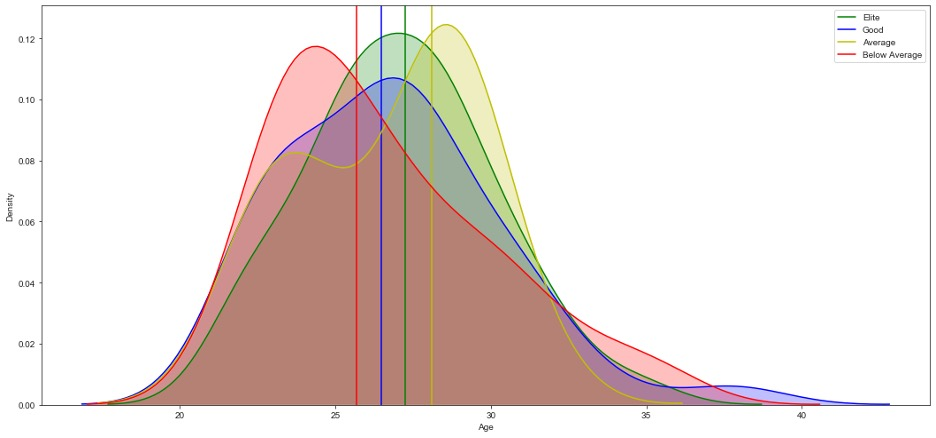

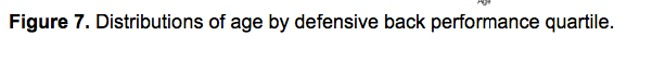

# Appendix



# Additional Take aways
* Cover 2 Man has the lowest completion percentage of 43.5% and while Cover 2 Zone has the highest with 66.5% completion. 
* Cover 2 Man has the highest Sack rate at 9.7%
* Cover 0 Man has the lowest mean yds gained of 1.28, however it is infrequently used by the defense and only used against short offensive plays.
* The highest interception rate is Cover 0 Man with 2.8% and the worst is Cover 2 Zone with 1.7%.
* Cover 3 zone and Cover 1 Man are most frequently used as they provide protection against long passes in which Cover 0 Man and Cover 1 Man leave exposed.****